In [292]:
import pandas as pd
import sqlite3
conn = sqlite3.connect('./database.sqlite')
c = conn.cursor()

In [293]:
c.execute("""SELECT m.id, c.name AS country_name, l.name AS league_name, season, stage, date,
             HT.team_long_name AS  home_team, AT.team_long_name AS away_team, home_team_goal, away_team_goal                                        
             FROM Match m
             JOIN Country c on c.id = m.country_id
             JOIN League l on l.id = m.league_id
             LEFT JOIN Team AS HT on HT.team_api_id = m.home_team_api_id
             LEFT JOIN Team AS AT on AT.team_api_id = m.away_team_api_id
             ORDER by date""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head(5)
#print(len(df))

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,24559,Switzerland,Switzerland Super League,2008/2009,1,2008-07-18 00:00:00,BSC Young Boys,FC Basel,1,2
1,24560,Switzerland,Switzerland Super League,2008/2009,1,2008-07-19 00:00:00,FC Aarau,FC Sion,3,1
2,24561,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,FC Luzern,FC Vaduz,1,2
3,24562,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20 00:00:00,Neuchâtel Xamax,FC Zürich,1,2
4,24613,Switzerland,Switzerland Super League,2008/2009,2,2008-07-23 00:00:00,FC Basel,Grasshopper Club Zürich,1,0


In [294]:
df['date'] = pd.to_datetime(df.date)

In [295]:
df.loc[df["home_team_goal"] > df["away_team_goal"], "Home_Win"] = 1 
df.loc[df["away_team_goal"] > df["home_team_goal"], "Away_Win"] = 1 
df.loc[df["away_team_goal"] == df["home_team_goal"], "Draw"] = 1

In [296]:
df['Away_Win'] = df['Away_Win'].fillna(0)
df['Away_Win'] = df['Away_Win'].astype(int)
df['Home_Win'] = df['Home_Win'].fillna(0)
df['Home_Win'] = df['Home_Win'].astype(int)
df['Draw'] = df['Draw'].fillna(0)
df['Draw'] = df['Draw'].astype(int)

In [297]:
team_names = df['home_team'].unique()
len(team_names)

296

In [298]:
df.head()

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,Home_Win,Away_Win,Draw
0,24559,Switzerland,Switzerland Super League,2008/2009,1,2008-07-18,BSC Young Boys,FC Basel,1,2,0,1,0
1,24560,Switzerland,Switzerland Super League,2008/2009,1,2008-07-19,FC Aarau,FC Sion,3,1,1,0,0
2,24561,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20,FC Luzern,FC Vaduz,1,2,0,1,0
3,24562,Switzerland,Switzerland Super League,2008/2009,1,2008-07-20,Neuchâtel Xamax,FC Zürich,1,2,0,1,0
4,24613,Switzerland,Switzerland Super League,2008/2009,2,2008-07-23,FC Basel,Grasshopper Club Zürich,1,0,1,0,0


In [299]:
#total_wins = (df.groupby('home_team')['Home_Win'].sum()) + (df.groupby('away_team')['Away_Win'].sum())
#total_matches = (df['home_team'].value_counts()) + (df['away_team'].value_counts())
#total_draws = df.groupby('home_team')['Draw'].sum() + df.groupby('away_team')['Draw'].sum()
#total_losses = total_matches - (total_wins + total_draws)

#df = pd.concat([total_goals, total_wins, total_losses], axis=1)
#df.columns = ['Total_Goals', 'Total_Wins', 'Total_Losses']
#df.index.names = ['Team']
#df.head()

In [300]:
#Home_Record = df.groupby(['season', 'home_team'])['Home_Win', 'Away_Win', 'Draw'].sum()
Home_Record = df.groupby(['home_team'])['Home_Win', 'Away_Win', 'Draw'].sum()
Home_Record.rename(columns={'Away_Win': 'Home_Loss', 'Draw': 'Home_Draw'}, inplace=True)
Away_Record = df.groupby(['away_team'])['Home_Win', 'Away_Win', 'Draw'].sum()
Away_Record.rename(columns={'Home_Win': 'Away_Loss', 'Draw': 'Away_Draw'}, inplace=True)
Home_Record.index.names = ['team']
Away_Record.index.names = ['team']

In [301]:
len(Home_Record)

296

In [302]:
Goals_Scored = (df.groupby(['home_team'])['home_team_goal'].sum()) + (df.groupby(['away_team'])['away_team_goal'].sum())
Goals_Allowed = (df.groupby(['home_team'])['away_team_goal'].sum()) + (df.groupby(['away_team'])['home_team_goal'].sum())
Goals_Allowed.index.names = ['team']
Goals_Scored.index.names = ['team']

In [303]:
df = pd.concat([Home_Record, Away_Record, Total_Goals_Scored, Total_Goals_Allowed], axis=1)
len(df)

296

In [304]:
df.rename(columns={0: 'Goals_Scored', 1: 'Goals_Allowed' }, inplace=True)

In [305]:
df['Total_Wins'] = df['Home_Win'] + df['Away_Win']
df['Total_Losses'] = df['Home_Loss'] + df['Away_Loss']
df['Total_Draws'] = df['Home_Draw'] + df['Away_Draw']

In [306]:
df['Total_Matches'] = df['Total_Wins'] + df['Total_Losses'] + df['Total_Draws']

In [307]:
df['Win_%'] = (df['Total_Wins']/df['Total_Matches']).round(5)
df['Loss_%'] = (df['Total_Losses']/df['Total_Matches']).round(5)
df['Draw_%'] = (df['Total_Draws']/df['Total_Matches']).round(5)
df['Home_Win_%'] = (df['Home_Win'])/(df['Home_Win'] + df['Home_Loss'] + df['Home_Draw']).round(5)
df['Away_Win_%'] = (df['Away_Win'])/(df['Away_Win'] + df['Away_Loss'] + df['Away_Draw']).round(5)

In [308]:
pd.set_option('display.max_columns', 100)
df.head(5)

,Home_Win,Home_Loss,Home_Draw,Away_Loss,Away_Win,Away_Draw,Goals_Scored,Goals_Allowed,Total_Wins,Total_Losses,Total_Draws,Total_Matches,Win_%,Loss_%,Draw_%,Home_Win_%,Away_Win_%
team,,,,,,,,,,,,,,,,,
1. FC Kaiserslautern,8,15,11,18,9,7,72,105,17,33,18,68,0.25000,0.48529,0.26471,0.235294,0.264706
1. FC Köln,32,39,31,51,28,23,226,311,60,90,54,204,0.29412,0.44118,0.26471,0.313725,0.274510
1. FC Nürnberg,30,34,21,44,19,22,193,269,49,78,43,170,0.28824,0.45882,0.25294,0.352941,0.223529
1. FSV Mainz 05,55,35,29,50,33,36,320,319,88,85,65,238,0.36975,0.35714,0.27311,0.462185,0.277311
AC Ajaccio,16,22,19,30,6,21,116,184,22,52,40,114,0.19298,0.45614,0.35088,0.280702,0.105263


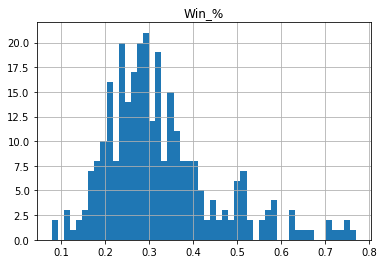

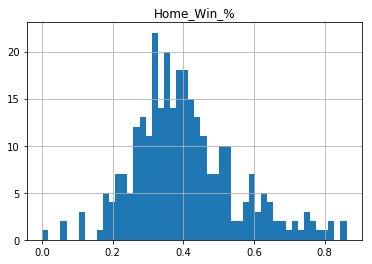

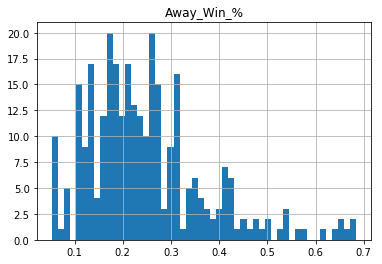

In [309]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df.hist('Win_%', bins=50)
df.hist('Home_Win_%', bins=50)
df.hist('Away_Win_%', bins=50)
plt.show()

In [310]:
df_mean = df['Win_%'].mean()
df_std = df['Win_%'].std()
print('df_mean is {} \df_std is {}'.format(df_mean,df_std))

df_mean is 0.3260735472972973 \df_std is 0.12779514752432447


In [311]:
import numpy as np

def one_sample_mean(df):
    sample = np.random.choice(df,size=500,replace=True)
    return sample.mean()

In [312]:
one_sample_mean(df['Win_%'])

0.32952608

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2de8b240>]],
      dtype=object)

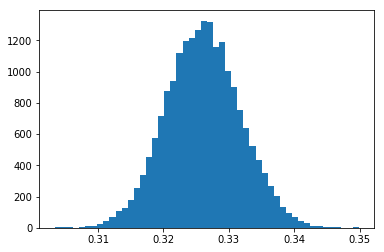

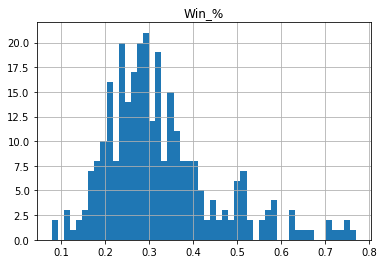

In [313]:
d = [one_sample_mean(df['Win_%']) for i in range(20000)]
plt.hist(d,bins=50)
df.hist('Win_%', bins=50)

In [314]:
import scipy.stats as scs
n = 296
mean = 0.326
t_value = scs.t.ppf(0.95,n-1)
margin_error = t_value* 0.4/(n**0.5)
confidence_interval = (mean - margin_error, mean + margin_error)
print(margin_error)
print(confidence_interval)

0.038362541585068285
(0.2876374584149317, 0.3643625415850683)


In [315]:
#scipy.stats.ttest_ind(Mean_HOME, Mean_Away)

In [316]:
import pandas as pd
import numpy as np
from scipy import stats
import itertools

#standard error = standard deviation / sqrt of # of observations
se = 0.12779514752432447 / np.sqrt(296)
se

0.007427942071310381

In [317]:
#z = (value you're interested in - mean)/ 
z = (.64 - 0.326073) / se
z
#stats.norm.sf(z)

42.26298441563094

In [318]:
stats.norm.sf(z)

0.0

In [319]:
c.execute("""SELECT a.team_fifa_api_id, HT.team_long_name AS  home_team, a.date, a.buildUpPlaySpeed, a.buildUpPlayPassing, a.chanceCreationPassing, a.chanceCreationCrossing, a.chanceCreationShooting, a.defencePressure, a.defenceAggression, a.defenceTeamWidth
             FROM Team_Attributes a
             LEFT JOIN Team AS HT on HT.team_api_id = a.team_api_id
             ORDER by date""")
fifa_df = pd.DataFrame(c.fetchall())
fifa_df.columns = [x[0] for x in c.description]
print(len(fifa_df))
fifa_df.head()
fifa_df['date'] = pd.to_datetime(fifa_df.date)
fifa_df.head()

1458


,team_fifa_api_id,home_team,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,434,FC Aarau,2010-02-22,60,50,60,65,55,50,55,45
1,77,Aberdeen,2010-02-22,70,70,70,70,70,60,70,70
2,614,AC Ajaccio,2010-02-22,60,40,45,35,55,30,70,30
3,47,Milan,2010-02-22,45,30,55,45,70,30,35,60
4,1901,Académica de Coimbra,2010-02-22,30,30,50,60,55,30,30,30


In [320]:
fifa_df['Cumulative_Score'] = (fifa_df['buildUpPlaySpeed'] + fifa_df['buildUpPlayPassing'] + fifa_df['chanceCreationPassing'] + fifa_df['chanceCreationCrossing'] + fifa_df['chanceCreationShooting'] + fifa_df['defencePressure'] + fifa_df['defenceAggression'] + fifa_df['defenceTeamWidth'])/8

In [321]:
fifa_df = fifa_df.groupby(['home_team'])['buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure', 'defenceAggression', 'defenceTeamWidth', 'Cumulative_Score'].mean()
len(fifa_df)

285

In [322]:
full_df = df.join(fifa_df, how='right')
full_df
#print(len(full_df))

,Home_Win,Home_Loss,Home_Draw,Away_Loss,Away_Win,Away_Draw,Goals_Scored,Goals_Allowed,Total_Wins,Total_Losses,Total_Draws,Total_Matches,Win_%,Loss_%,Draw_%,Home_Win_%,Away_Win_%,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,Cumulative_Score
home_team,,,,,,,,,,,,,,,,,,,,,,,,,,
1. FC Kaiserslautern,8,15,11,18,9,7,72,105,17,33,18,68,0.25000,0.48529,0.26471,0.235294,0.264706,51.166667,51.666667,47.166667,62.000000,59.666667,46.833333,52.833333,55.166667,53.312500
1. FC Köln,32,39,31,51,28,23,226,311,60,90,54,204,0.29412,0.44118,0.26471,0.313725,0.274510,57.333333,61.166667,55.166667,41.666667,59.000000,45.000000,51.166667,60.833333,53.916667
1. FC Nürnberg,30,34,21,44,19,22,193,269,49,78,43,170,0.28824,0.45882,0.25294,0.352941,0.223529,45.333333,47.500000,50.500000,53.000000,59.166667,43.333333,50.500000,44.000000,49.166667
1. FSV Mainz 05,55,35,29,50,33,36,320,319,88,85,65,238,0.36975,0.35714,0.27311,0.462185,0.277311,61.833333,51.500000,53.000000,47.666667,54.500000,52.500000,62.500000,49.666667,54.145833
AC Ajaccio,16,22,19,30,6,21,116,184,22,52,40,114,0.19298,0.45614,0.35088,0.280702,0.105263,60.166667,48.833333,50.333333,40.666667,52.166667,37.833333,50.500000,48.666667,48.645833
AC Arles-Avignon,2,11,6,13,1,5,21,70,3,24,11,38,0.07895,0.63158,0.28947,0.105263,0.052632,43.166667,53.166667,46.000000,38.333333,39.500000,38.333333,46.000000,46.333333,43.854167
AC Bellinzona,17,24,13,34,8,12,128,218,25,58,25,108,0.23148,0.53704,0.23148,0.314815,0.148148,43.500000,52.000000,55.000000,51.500000,55.000000,38.500000,50.000000,55.500000,50.125000
ADO Den Haag,50,47,39,72,29,35,366,468,79,119,74,272,0.29044,0.43750,0.27206,0.367647,0.213235,45.500000,50.000000,49.666667,56.000000,50.166667,45.500000,51.333333,52.166667,50.041667
AJ Auxerre,31,18,27,31,22,23,168,162,53,49,50,152,0.34868,0.32237,0.32895,0.407895,0.289474,53.500000,55.166667,45.666667,63.666667,47.500000,33.500000,46.666667,41.333333,48.375000


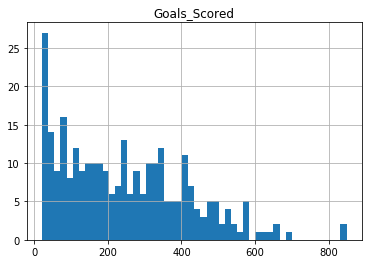

In [324]:
full_df.hist('Goals_Scored', bins=50)
plt.show()

In [325]:
full_df_mean = full_df['Goals_Scored'].mean()
full_df_std = full_df['Goals_Scored'].std()
print('df_mean is {} \df_std is {}'.format(full_df_mean,full_df_std))

df_mean is 245.3438596491228 \df_std is 170.046475645386


In [326]:
import numpy as np

def one_sample_mean(df):
    sample = np.random.choice(df, size=1000,replace=True)
    return sample.mean()

In [327]:
one_sample_mean(full_df['Goals_Scored'])

243.878

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a30c22e48>]],
      dtype=object)

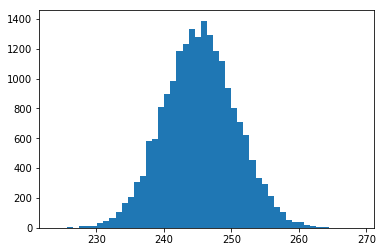

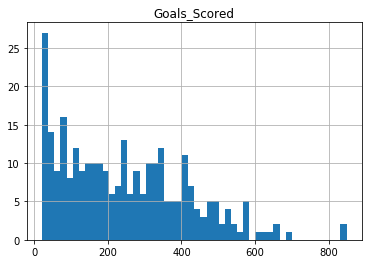

In [329]:
d = [one_sample_mean(full_df['Goals_Scored']) for i in range(20000)]
plt.hist(d,bins=50)
full_df.hist('Goals_Scored', bins=50)

In [247]:
import scipy.stats as scs
n = 285
mean = 50.8483845
t_value = scs.t.ppf(0.95,n-1)
margin_error = t_value* 0.4/(n**0.5)
confidence_interval = (mean - margin_error, mean + margin_error)
print(margin_error)
print(confidence_interval)

0.03910063340050227
(50.8092838665995, 50.8874851334005)


In [255]:
import pandas as pd
import numpy as np
from scipy import stats
import itertools

#standard error = standard deviation / sqrt of # of observations
se = 3.5336131499880103 / np.sqrt(285)
se

0.2093131783830169

In [257]:
#z = (value you're interested in - mean)/ 
z = (53 - 50.8483845) / se
z
#stats.norm.sf(z)

10.27940771155274

In [258]:
stats.norm.sf(z)

4.363109719910872e-25